## Building Flexible Audio DDSP Pipelines: A Case Study on Artificial Reverb
**DAFx25 Tutorial - September 2, 2025**  
*International Conference on Digital Audio Effects DAFx, Ancona (IT)*

### FDN Parameter Optimization for Room Impulse Response Matching

This notebook demonstrates how to build and optimize a differentiable Feedback Delay Network (FDN) to match the reverberation characteristics of a measured room impulse response (RIR). The tutorial covers:

- Loading and preprocessing target RIR and anechoic audio
- Creating a differentiable FDN with configurable parameters
- Setting up optimization with multiple loss functions
- Training the FDN to match target acoustic characteristics
- Analyzing and comparing results

In [1]:
# --- Imports ---
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from pathlib import Path
from flamo.optimize.dataset import Dataset, load_dataset 
from flamo.optimize.trainer import Trainer               
from ddsp.fdn import BaseFDN                             
from ddsp.utils import *                                 
from ddsp.loss import mss_loss, sparsity_loss           
from scipy.signal import resample_poly                   

# --- Device Configuration ---
torch.set_default_dtype(torch.float32)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# --- Audio Configuration ---
fs = 44100          # Sampling rate
nfft = 2 * fs       # FFT size 
ir_len = nfft       # Length of impulse response 

Using device: cpu


### Target RIR and Anechoic Audio Loading

Load the target room impulse response (RIR) that our FDN should match and an anechoic audio signal for testing.

Loaded target RIR: (105840,), fs=44100Hz
✓ Sampling rate validation passed
Target RIR Audio:


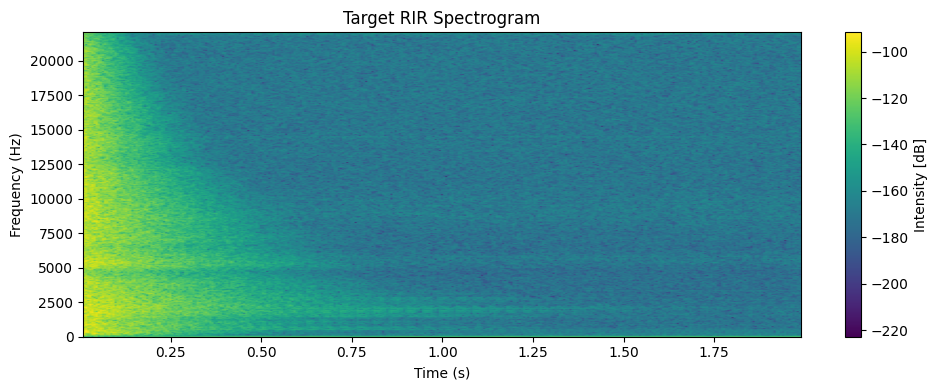

In [2]:
# --- Target RIR Loading ---
# Load the target RIR from the data directory
target_path = Path("..") / '..' / "data" / "rirs" / "arni_35.wav"
target_rir_np, fs_target = audioread(str(target_path))
print(f"Loaded target RIR: {target_rir_np.shape}, fs={fs_target}Hz")

# --- Onset Detection and Preprocessing ---
# Detect the onset and remove initial silence since our model does not model the direct sound
onset_time = find_onset(target_rir_np).item()
target_rir_np = target_rir_np[onset_time:onset_time+ir_len]

# Convert to tensor format expected by the model (batch_size=1, n_samples, channels=1)
target_rir = torch.tensor(target_rir_np, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
target_energy = torch.sum(torch.abs(torch.fft.rfft(target_rir, nfft, dim=1))**2)
target_rir = target_rir / torch.sqrt(target_energy)  # Normalize energy

# --- Sampling Rate Validation ---
# Ensure the target RIR matches the model's sampling rate
assert fs_target == fs, f"Sampling rate mismatch: target={fs_target}Hz, model={fs}Hz"
print("✓ Sampling rate validation passed")

# --- Target RIR Visualization ---
print("Target RIR Audio:")
ipd.display(ipd.Audio(target_rir_np, rate=fs))
plot_spectrogram(target_rir_np, fs=fs, title="Target RIR Spectrogram", clim=[None, None])

In [3]:
# --- Anechoic Audio Loading ---
# Load an anechoic (dry) audio signal for evaluation and testing
anechoic_path = Path('..') / '..'/  'data' / 'anechoic' / 'Drums.wav'
anechoic_np, anechoic_fs = audioread(str(anechoic_path))
print(f"Loaded anechoic audio: {anechoic_np.shape}, fs={anechoic_fs}Hz")

# Ensure the anechoic audio matches the FDN's sampling rate
if anechoic_fs != fs:
    print(f"Resampling anechoic audio from {anechoic_fs}Hz to {fs}Hz")
    anechoic_np = resample_poly(anechoic_np, fs, anechoic_fs)

# Convert to tensor format (batch_size=1, n_samples, channels=1)
anechoic = torch.tensor(anechoic_np, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

print("Anechoic Input Audio:")
ipd.display(ipd.Audio(anechoic_np, rate=fs))

Loaded anechoic audio: (240000,), fs=48000Hz
Resampling anechoic audio from 48000Hz to 44100Hz
Anechoic Input Audio:


### FDN Model Creation and Initialization

Create a differentiable Feedback Delay Network (FDN) and configure it for optimization:

- **FDN Architecture**: The `BaseFDN` class implements the complete FDN structure with configurable parameters
- **Delay Lines**: Set specific delay lengths to avoid unwanted resonances
- **Attenuation Type**: Use GEQ (Graphic Equalizer) for frequency-dependent attenuation control
- **Energy Normalization**: Match the energy level to the target RIR for faster convergence
- **Initial Response**: Visualize the randomly initialized FDN response before optimization

*Note*: The impulse response tensor has shape `(batch_size, n_samples, channels)` following FLAMO convention. We need to squeeze dimensions for proper visualization.

FDN configuration: N=6 delay lines, delays=[997, 1153, 1327, 1559, 1801, 2099]
FDN Model:
Shell(
  (_Shell__core): Series(
    (input_gains): Gain()
    (feedback_loop): Recursion(
      (feedforward): parallelDelay()
      (feedback): Series(
        (mixing_matrix): Matrix()
        (attenuation): parallelGEQ()
      )
    )
    (output_gains): Gain()
  )
  (_Shell__input_layer): FFT()
  (_Shell__output_layer): iFFTAntiAlias()
)


/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/conferences/dafx25/dafx25-ddsp-tutorial/src/ddsp/fdn.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delay_lengths = torch.tensor(delay_lengths, dtype=torch.int64)


Initial FDN impulse response shape: (88200,)


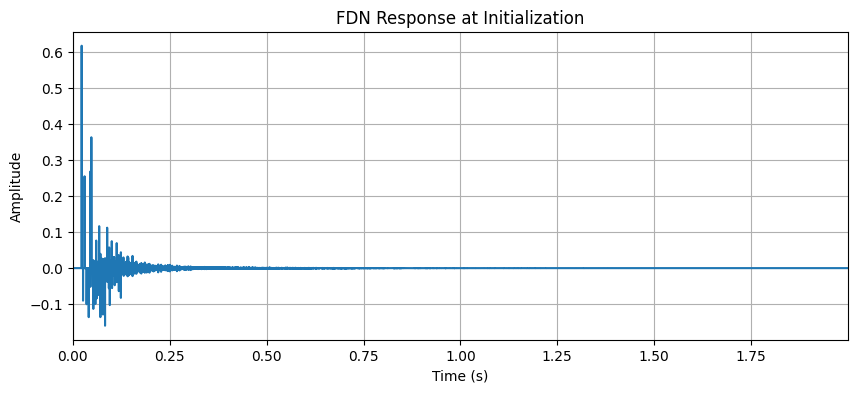

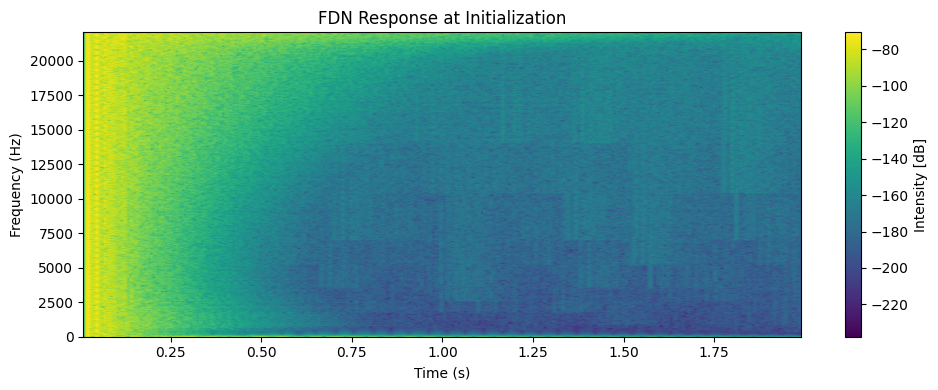

Initial FDN processed audio:


In [4]:
# --- FDN Delay Configuration ---
# Define delay line lengths - these values are chosen to avoid unwanted resonances
delays = torch.tensor([997, 1153, 1327, 1559, 1801, 2099])
N = len(delays)
print(f"FDN configuration: N={N} delay lines, delays={delays.tolist()}")

# --- Create Differentiable FDN ---
# Initialize the BaseFDN with configurable parameters
fdn = BaseFDN(
    N=N,                           # Number of delay lines
    fs=fs,                         # Sampling rate
    nfft=nfft,                     # FFT size for frequency domain processing
    delay_lengths=delays,          # Delay line lengths in samples
    alias_decay_db=0,              # Time aliasing mitigation (0 = no mitigation, but that's ok since we have attenuations)
    device=device,                 
    attenuation_type="GEQ",        # Graphic Equalizer for frequency-dependent attenuation
)

# --- Model Shell Access ---
# For convenience, create a reference to the shell object (the actual DDSP)
model = fdn.shell
print("FDN Model:")
print(model)

# Normalize the FDN energy to match the target RIR for faster convergence
fdn.normalize_energy(1)

# --- Initial Response Analysis ---
# Get the impulse response of the randomly initialized FDN
ir = model.get_time_response().squeeze().numpy()
print(f"Initial FDN impulse response shape: {ir.shape}")

# Plot time domain and spectrogram of the initial FDN response
plot_time_domain(ir, fs=fs, title="FDN Response at Initialization")
plot_spectrogram(ir, fs=fs, title="FDN Response at Initialization", clim=[None, None])

# Process the target RIR through the initial FDN to hear how it sounds
init_output = model(target_rir)
print("Initial FDN processed audio:")
ipd.display(ipd.Audio(init_output.squeeze().detach().numpy(), rate=fs))

### Training Setup and Optimization

Configure the training pipeline for FDN parameter optimization:

- Use impulse input signal
- Combine multiple loss functions for better optimization:
  - **Sparsity Loss**: Encourages density of the mixing matrix
  - **Multiscale STFT Loss (MSS)**: Matches spectral characteristics across multiple time scales
- Set epochs, learning rate, and optimization parameters
- Use the FLAMO framework's training pipeline to optimize the DDSP

The training process optimizes FDN parameters to minimize the combined loss between the FDN output and target RIR.

In [5]:
# --- Training Dataset Creation ---
# Create impulse input signal for system identification
input_imp = torch.zeros(1, ir_len, 1)
input_imp[:, 0, :] = 1  # Set first sample to 1 (unit impulse)
print(f"Created impulse input: shape={input_imp.shape}")

# --- Dataset and DataLoader Setup ---
# Generate dataset with input-target pairs and data augmentation
dataset = Dataset(
    input=input_imp,        
    target=target_rir,      
    expand=128              # this coincides with the number of iterations gradient descent
)
train_loader, valid_loader = load_dataset(dataset, batch_size=1)
print(f"Dataset created with {len(dataset)} samples")

# --- Trainer Configuration ---
# Set up the FLAMO trainer with optimization parameters
max_epochs = 10
trainer = Trainer(
    model,                 
    max_epochs=max_epochs, 
    lr=1e-3,               # Learning rate for gradient descent
    step_size=10,          # Learning rate scheduler step size
    patience_delta=1e-6,   # Early stopping threshold
    train_dir=str(Path("../../data")),  # Directory for saving checkpoints
)

# --- Register Loss Functions ---
# Define loss function weights for multi-objective optimization
alpha = [1.0, 2.5e2]  # [sparsity_weight, mss_weight]
print(f"Loss weights: sparsity={alpha[0]}, MSS={alpha[1]}")

# Register sparsity loss to encourage sparse parameter values
trainer.register_criterion(
    sparsity_loss(),        # Sparsity loss function
    alpha=alpha[0],         # Weight for sparsity loss
    requires_model=True     # This loss needs access to model parameters
)

# Register Multiscale STFT loss
trainer.register_criterion(
    mss_loss(energy_norm=True, sample_rate=fs),  # MSS loss with energy normalization
    alpha=alpha[1],              # Weight for MSS loss             
)

# --- Start Training ---
print("Starting FDN optimization...")
trainer.train(train_dataset=train_loader, valid_dataset=valid_loader)
print("Training completed!")

Created impulse input: shape=torch.Size([1, 88200, 1])
Dataset created with 128 samples
Loss weights: sparsity=1.0, MSS=250.0
Starting FDN optimization...


Training:  10%|█         | 1/10 [02:31<22:45, 151.74s/it]

epoch:   0 - train_loss: 0.5893 - test_loss: 0.5429 - time: 151.7325 s


Training:  20%|██        | 2/10 [05:08<20:36, 154.53s/it]

epoch:   1 - train_loss: 0.5116 - test_loss: 0.4848 - time: 156.4782 s


Training:  30%|███       | 3/10 [07:14<16:32, 141.82s/it]

epoch:   2 - train_loss: 0.4656 - test_loss: 0.4487 - time: 126.6861 s


Training:  40%|████      | 4/10 [09:17<13:25, 134.30s/it]

epoch:   3 - train_loss: 0.4358 - test_loss: 0.4242 - time: 122.7676 s


Training:  50%|█████     | 5/10 [11:20<10:50, 130.16s/it]

epoch:   4 - train_loss: 0.4152 - test_loss: 0.4070 - time: 122.8162 s


Training:  60%|██████    | 6/10 [13:25<08:33, 128.43s/it]

epoch:   5 - train_loss: 0.4006 - test_loss: 0.3949 - time: 125.0664 s


Training:  70%|███████   | 7/10 [15:28<06:19, 126.66s/it]

epoch:   6 - train_loss: 0.3905 - test_loss: 0.3866 - time: 123.0055 s


Training:  80%|████████  | 8/10 [5:23:51<3:19:13, 5976.92s/it]

epoch:   7 - train_loss: 0.3836 - test_loss: 0.3809 - time: 18503.3371 s


Training:  90%|█████████ | 9/10 [7:13:32<1:42:45, 6165.53s/it]

epoch:   8 - train_loss: 0.3789 - test_loss: 0.3771 - time: 6580.2353 s


Training: 100%|██████████| 10/10 [7:15:41<00:00, 2614.14s/it] 

epoch:   9 - train_loss: 0.3757 - test_loss: 0.3745 - time: 129.1888 s
Training time: 26141.431s
Training completed!


### Results Analysis and Comparison

Analyze the optimization results and compare the learned FDN response with the target.

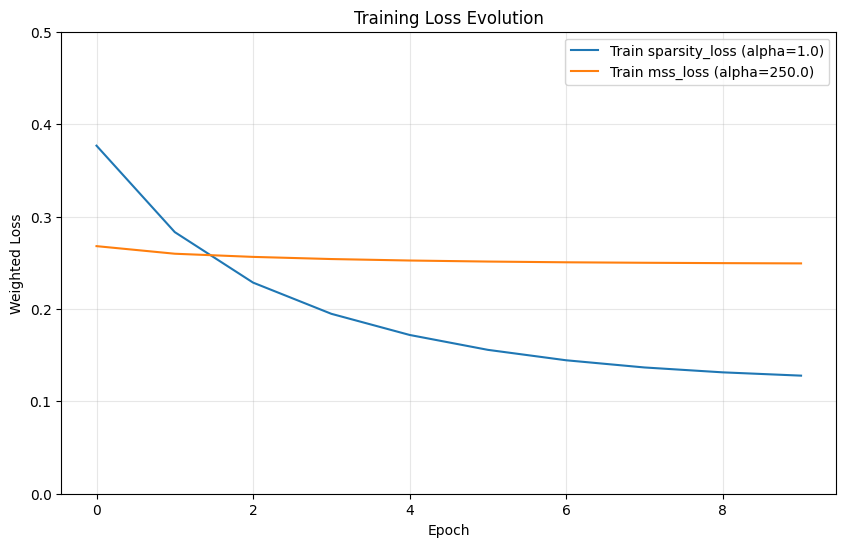

Optimized FDN impulse response shape: (88200,)


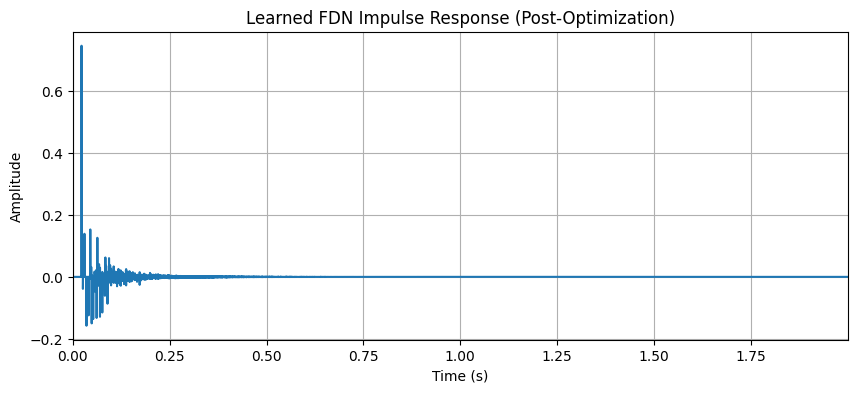

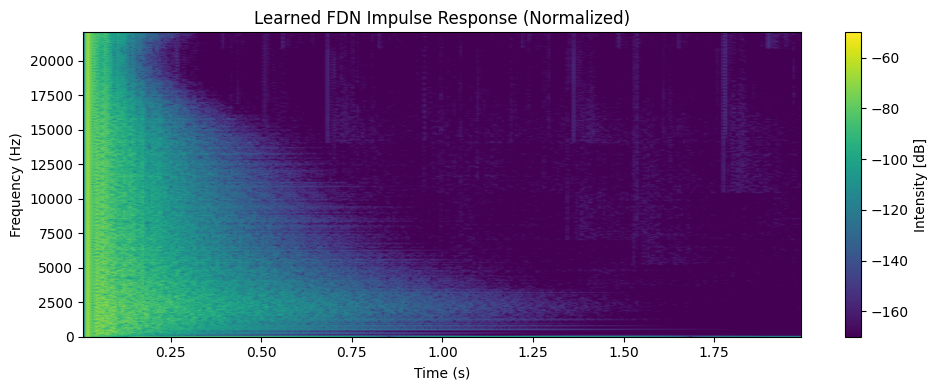

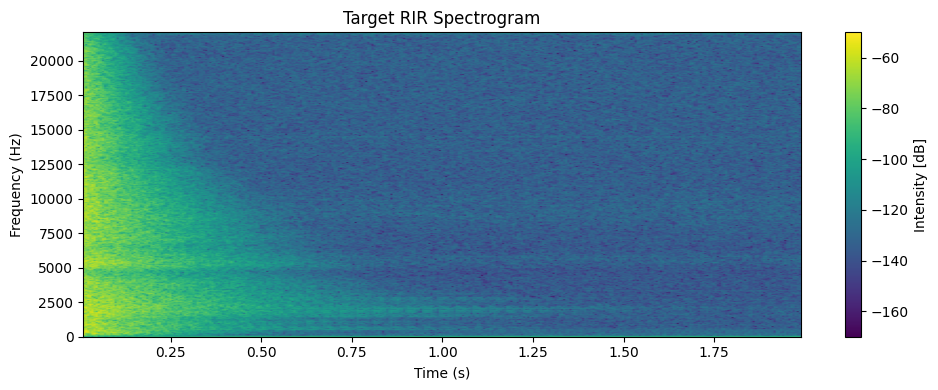

🎵 Audio Comparison:
Optimized FDN convolved with anechoic audio:


Target RIR convolved with anechoic audio:


In [9]:
# --- Training Loss Visualization ---
# Plot the evolution of loss functions during training
plt.figure(figsize=(10, 6))
for i, key in enumerate(trainer.train_loss_log.keys()):
    n_steps = len(trainer.train_loss_log[key])
    # Scale loss values by their respective weights for comparison
    loss_values = np.array(trainer.train_loss_log[key][:: n_steps // max_epochs]) * alpha[i]
    plt.plot(loss_values, label=f"Train {key} (alpha={alpha[i]})")

plt.ylim([0, 0.5])
plt.xlabel("Epoch")
plt.ylabel("Weighted Loss")
plt.title("Training Loss Evolution")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Learned Impulse Response Analysis ---
# Get the optimized FDN impulse response
ir_out = model.get_time_response().squeeze().numpy()
print(f"Optimized FDN impulse response shape: {ir_out.shape}")

# Plot the learned impulse response in time domain
plot_time_domain(
    ir_out,
    fs=fs,
    title="Learned FDN Impulse Response (Post-Optimization)",
)

# Plot the learned impulse response in time-freq domain
plot_spectrogram(
    ir_out/np.max(np.abs(ir_out)),
    fs=fs,
    title="Learned FDN Impulse Response (Normalized)",
    clim=[-170, -50],
)

# Plot target RIR spectrogram
plot_spectrogram(
    target_rir.squeeze().numpy()/np.max(np.abs(target_rir.squeeze().numpy())),
    fs=fs,
    title="Target RIR Spectrogram",
    clim=[-170, -50],
)

# Compare audio results by convolving with anechoic signal
print("🎵 Audio Comparison:")
print("Optimized FDN convolved with anechoic audio:")
fdn_convolved = np.convolve(ir_out, anechoic_np, 'full')
ipd.display(ipd.Audio(fdn_convolved, rate=fs))

print("Target RIR convolved with anechoic audio:")
target_convolved = np.convolve(target_rir.squeeze().numpy(), anechoic_np, 'full')
ipd.display(ipd.Audio(target_convolved, rate=fs))
